# Simulation of the model through numerical integration


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation


Define the forward kinematics function to compute the position of the end-effector and the first joint given the joint angles.
Define a function to make an animation of the robot given the positions of the two masses.


In [2]:
def fk_ext(x1, x2, L1, L2):
    """Forward kinematics with extension to plot the robot, given the joint angles and link lengths.

    Args:
        x1 (floa): first joint angle
        x2 (float): second joint angle
        L1 (float): first link length
        L2 (float): second link length

    Returns:
        tuple: (p_x1, p_y1, p_x2, p_y2) - coordinates of the first and second link
    """

    # first link position
    p_x1 = L1 * np.cos(x1)
    p_y1 = L1 * np.sin(x1)
    # end effector position
    p_x2 = L1 * np.cos(x1) + L2 * np.cos(x1 + x2)
    p_y2 = L1 * np.sin(x1) + L2 * np.sin(x1 + x2)

    return np.asarray([p_x1, p_y1, p_x2, p_y2])


def make_animation(positions, time, name, ax, fig, **plt_kwargs):
    # retrieve the positions
    l1x, l1y, l2x, l2y = positions
    # create the figure
    ax.set_facecolor("k")
    ax.get_xaxis().set_ticks([])  # enable this to hide x axis ticks
    ax.get_yaxis().set_ticks([])  # enable this to hide y axis ticks
    ax.set_ylim(-4, 4)
    ax.set_xlim(-4, 4)

    # define the animation function
    def animate(frame):
        ln1.set_data([0, l1x[frame], l2x[frame]], [0, l1y[frame], l2y[frame]])

    # plot the first frame
    (ln1,) = plt.plot([], [], "ro--", lw=3, markersize=8)
    # create the animation
    ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
    # save the animation
    ani.save(name, writer="pillow", fps=len(time[time < 1]))

> Euler Lagrange equations:

The equations of motion are derived using the Lagrangian method. The assumptions are:

- the two masses are point masses
- the two masses are connected by a massless rigid rod
- the rod is connected to the first joint by a massless hinge
- the rod is connected to the second joint by a massless hinge
- the rod is connected to the ground by a massless hinge
- the frictions are proportional to joint's velocities through the coefficients matrix $F$ diagonal and semi-positive definite
- the gravity is acting on the two masses (the model is compatible with perpendicular gravity also)
- the two joints are actuated by torques $\tau_1$ and $\tau_2$
- the two joints are revolute

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{q}_i} - \frac{\partial L}{\partial q_i} + \frac{\partial \mathbb{F}}{\partial \dot{q}_i}= \tau_i$$

Using matrix notation, we have:
$$M(q)\ddot{q} + C(q,\dot{q}) + G(q) = \tau$$
where:

- $M(q)$ is the inertia matrix
- $C(q,\dot{q})$ is the Coriolis and centrifugal matrix
- $G(q)$ is the gravity matrix
- $\tau$ is the vector of the torques
  > State Space representation:

We define $q$ as the vector of the joint angles and $\dot{q}$ as the vector of the joint velocities. The state space representation is defined as:
$x=\begin{bmatrix} q & \dot{q} \end{bmatrix}^T$, then we have:

$$
x=\begin{bmatrix}x_1 \\ x_2 \\ x_3 \\ x_4\end{bmatrix} = \begin{bmatrix} q_1 \\ q_2 \\ \dot{q}_1 \\\dot{q}_2 \end{bmatrix}
\Longrightarrow
\dot{x}=\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4\end{bmatrix} = \begin{bmatrix} x_3 \\ x_4 \\ \ddot{q}_1 \\ \ddot{q}_2 \end{bmatrix}
$$

In other words, we have:
$$\dot{x} = \begin{bmatrix} \dot{q} \\ M(q)^{-1}(\tau - C(q,\dot{q}) - G(q)) \end{bmatrix}$$


> Simulation:


In [3]:
# define the constants:
ti = 0
tf = 60
step = 0.0250
num_points = int((tf - ti) / step)+1
time = np.linspace(ti, tf, num_points, endpoint=True)
m1_ = 3
m2_ = 2
l1_ = 2
l2_ = 1
g_ = -9.81

# define the initial conditions
x_k = np.zeros((1, 4))
res = np.zeros((len(time), 4))
x_k_nf = np.zeros((1, 4))
res_nf = np.zeros((len(time), 4))
# define the torques
tau = [-1, 1]

# define constants
const = {'l1': l1_, 'l2': l2_, 'm1': m1_, 'm2': m2_, 'g': g_}

# determine if saturation is enabled
is_sat = True

In [4]:
# define the vector field function
def dxdt(x, constants, tau):
    """This function computes the time derivative of the state vector x.

    Args:
        x (np.array): state vector
        constant (dictionary): constants dictionary for the system
        tau (list): torques

    Returns:
        np.array: time derivative of the state vector
    """
    # unpack the state vector
    x1, x2, x3, x4 = x[0]
    # unpack the constants
    l1 = constants["l1"]
    l2 = constants["l2"]
    m1 = constants["m1"]
    m2 = constants["m2"]
    g = constants["g"]
    # unpack the torques
    t1, t2 = tau
    # compute the time derivative of the state vector
    dx1dt = x3
    dx2dt = x4
    dx3dt = (
        2 * l2 * t1 - 2 * l2 * t2 - 2 * l2 * x3 + 2 * l2 * x4
        - 2 * l1 * t2 * np.cos(x2) + 2 * l1 * x4 * np.cos(x2)
        - g * l1 * l2 * m2 * np.cos(x1 + 2 * x2)
        + l1** 2 * l2 * m2 * x3** 2 * np.sin(2 * x2) + 2 * l1 * l2** 2 * m2 * x3** 2 * np.sin(x2)
        + 2 * l1 * l2** 2 * m2 * x4** 2 * np.sin(x2)
        + 2 * g * l1 * l2 * m1 * np.cos(x1)
        + g * l1 * l2 * m2 * np.cos(x1)
        + 4 * l1 * l2** 2 * m2 * x3 * x4 * np.sin(x2)
    ) / (l1 ** 2 * l2 * (2 * m1 + m2 - m2 * np.cos(2 * x2)))
    dx4dt = -(
        l2** 2 * m2 * t1 - l1** 2 * m2 * t2 - l1** 2 * m1 * t2 - l2** 2 * m2 * t2 + l1** 2 * m1 * x4
        + l1** 2 * m2 * x4 - l2** 2 * m2 * x3 + l2** 2 * m2 * x4 + l1 * l2** 3 * m2** 2 * x3** 2 * np.sin(x2)
        + l1** 3 * l2 * m2** 2 * x3** 2 * np.sin(x2) + l1 * l2** 3 * m2** 2 * x4** 2 * np.sin(x2)
        + g * l1 * l2** 2 * m2** 2 * np.cos(x1) + l1** 2 * l2** 2 * m2** 2 * x3** 2 * np.sin(2 * x2)
        + (l1 ** 2 * l2 ** 2 * m2 ** 2 * x4 ** 2 * np.sin(2 * x2)) / 2
        + l1 * l2 * m2 * t1 * np.cos(x2) - 2 * l1 * l2 * m2 * t2 * np.cos(x2)
        - l1 * l2 * m2 * x3 * np.cos(x2) + 2 * l1 * l2 * m2 * x4 * np.cos(x2)
        + l1** 3 * l2 * m1 * m2 * x3** 2 * np.sin(x2) + 2 * l1 * l2** 3 * m2** 2 * x3 * x4 * np.sin(x2)
        + g * l1** 2 * l2 * m2** 2 * np.sin(x1) * np.sin(x2) + g * l1 * l2** 2 * m1 * m2 * np.cos(x1)
        - g * l1 * l2** 2 * m2** 2 * np.cos(x1) * np.cos(x2)** 2 + l1** 2 * l2** 2 * m2** 2 * x3 * x4 * np.sin(2 * x2)
        + g * l1 * l2** 2 * m2** 2 * np.cos(x2) * np.sin(x1) * np.sin(x2)
        + g * l1** 2 * l2 * m1 * m2 * np.sin(x1) * np.sin(x2)
    ) / (l1 ** 2 * l2 ** 2 * m2 * (-m2 * np.cos(x2) ** 2 + m1 + m2))

    return np.asarray([dx1dt, dx2dt, dx3dt, dx4dt])

# define the vector field function without friction

def dxdt_no_friction(x, constants, tau):
    """This function computes the time derivative of the state vector x.

    Args:
        x (np.array): state vector
        constant (dictionary): constants dictionary for the system
        tau (list): torques

    Returns:
        np.array: time derivative of the state vector
    """
    # unpack the state vector
    x1, x2, x3, x4 = x[0]
    # unpack the constants
    l1 = constants["l1"]
    l2 = constants["l2"]
    m1 = constants["m1"]
    m2 = constants["m2"]
    g = constants["g"]
    # unpack the torques
    t1, t2 = tau
    # compute the time derivative of the state vector
    dx1dt = x3
    dx2dt = x4
    dx3dt = (
        2*l2*t1 - 2*l2*t2 - 2*l1*t2*np.cos(x2) - g*l1*l2*m2*np.cos(x1 + 2*x2)
        + l1**2*l2*m2*x3**2*np.sin(2*x2) + 2*l1*l2**2*m2*x3**2*np.sin(x2)
        + 2*l1*l2**2*m2*x4**2*np.sin(x2) + 2*g*l1*l2*m1*np.cos(x1) + g*l1*l2*m2*np.cos(x1)
        + 4*l1*l2**2*m2*x3*x4*np.sin(x2)
    )/(l1**2*l2*(2*m1 + m2 - m2*np.cos(2*x2)))
    dx4dt = -(
        l2**2*m2*t1 - l1**2*m2*t2 - l1**2*m1*t2 - l2**2*m2*t2 + l1*l2**3*m2**2*x3**2*np.sin(x2)
        + l1**3*l2*m2**2*x3**2*np.sin(x2) + l1*l2**3*m2**2*x4**2*np.sin(x2) + g*l1*l2**2*m2**2*np.cos(x1)
        + l1**2*l2**2*m2**2*x3**2*np.sin(2*x2) + (l1**2*l2**2*m2**2*x4**2*np.sin(2*x2))/2
        + l1*l2*m2*t1*np.cos(x2) - 2*l1*l2*m2*t2*np.cos(x2) + l1**3*l2*m1*m2*x3**2*np.sin(x2)
        + 2*l1*l2**3*m2**2*x3*x4*np.sin(x2) + g*l1**2*l2*m2**2*np.sin(x1)*np.sin(x2)
        + g*l1*l2**2*m1*m2*np.cos(x1) - g*l1*l2**2*m2**2*np.cos(x1)*np.cos(x2)**2
        + l1**2*l2**2*m2**2*x3*x4*np.sin(2*x2) + g*l1*l2**2*m2**2*np.cos(x2)*np.sin(x1)*np.sin(x2)
        + g*l1**2*l2*m1*m2*np.sin(x1)*np.sin(x2)
    )/(l1**2*l2**2*m2*(- m2*np.cos(x2)**2 + m1 + m2))

    return np.asarray([dx1dt, dx2dt, dx3dt, dx4dt])

In [5]:
# simulate the system
for _ in range(1, num_points):
    # RK4 integration
    k1 = dxdt(x_k, const, tau)
    k2 = dxdt(x_k+step*k1/2, const, tau)
    k3 = dxdt(x_k+step*k2/2, const, tau)
    k4 = dxdt(x_k+step*k3, const, tau)
    # RK4 integration without friction
    k1_nf = dxdt_no_friction(x_k_nf, const, tau)
    k2_nf = dxdt_no_friction(x_k_nf+step*k1_nf/2, const, tau)
    k3_nf = dxdt_no_friction(x_k_nf+step*k2_nf/2, const, tau)
    k4_nf = dxdt_no_friction(x_k_nf+step*k3_nf, const, tau)
    # update the state vector
    x_k = x_k + step*(k1 + 2*k2 + 2*k3 + k4)/6
    x_k_nf = x_k_nf + step*(k1_nf + 2*k2_nf + 2*k3_nf + k4_nf)/6
    # saturate the angles to [-pi, pi] and [-5/6*pi, 5/6*pi]
    if is_sat:
        #x_k[0, 0] = np.mod(x_k[0, 0] + np.pi, 2*np.pi) - np.pi
        #x_k[0, 1] = np.mod(x_k[0, 1] + 5/6*np.pi, 10/6*np.pi) - 5/6*np.pi
        #x_k_nf[0, 0] = np.mod(x_k_nf[0, 0] + np.pi, 2*np.pi) - np.pi
        #x_k_nf[0, 1] = np.mod(x_k_nf[0, 1] + 5/6*np.pi, 10/6*np.pi) - 5/6*np.pi
        x_k[0, 0] = np.clip(x_k[0, 0], -np.pi, np.pi)
        x_k[0, 1] = np.clip(x_k[0, 1], -5/6*np.pi, 5/6*np.pi)
        x_k_nf[0, 0] = np.clip(x_k_nf[0, 0], -np.pi, np.pi)
        x_k_nf[0, 1] = np.clip(x_k_nf[0, 1], -np.pi, np.pi)
    # save the state vector
    res[_, :] = x_k
    res_nf[_, :] = x_k_nf

In [6]:
# evaluate the forward kinematics
p = fk_ext(res[:, 0], res[:, 1], l1_, l2_)
p_nf = fk_ext(res_nf[:, 0], res_nf[:, 1], l1_, l2_)

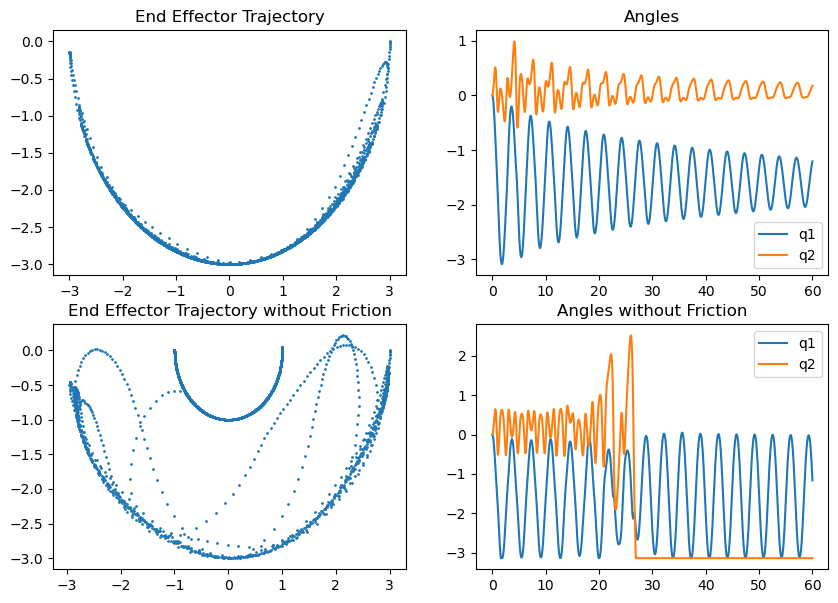

In [7]:
# plot the results
fig, ax = plt.subplots(2,2, figsize=(10,7))
ax[0,0].scatter(p[2, :], p[3, :], s=1)
ax[0,0].set_title("End Effector Trajectory")
ax[0,1].plot(time, res[:, 0], label="q1")
ax[0,1].plot(time, res[:, 1], label="q2")
ax[0,1].set_title("Angles")
ax[0,1].legend()
ax[1,0].scatter(p_nf[2, :], p_nf[3, :], s=1)
ax[1,0].set_title("End Effector Trajectory without Friction")
ax[1,1].plot(time, res_nf[:, 0], label="q1")
ax[1,1].plot(time, res_nf[:, 1], label="q2")
ax[1,1].set_title("Angles without Friction")
ax[1,1].legend()

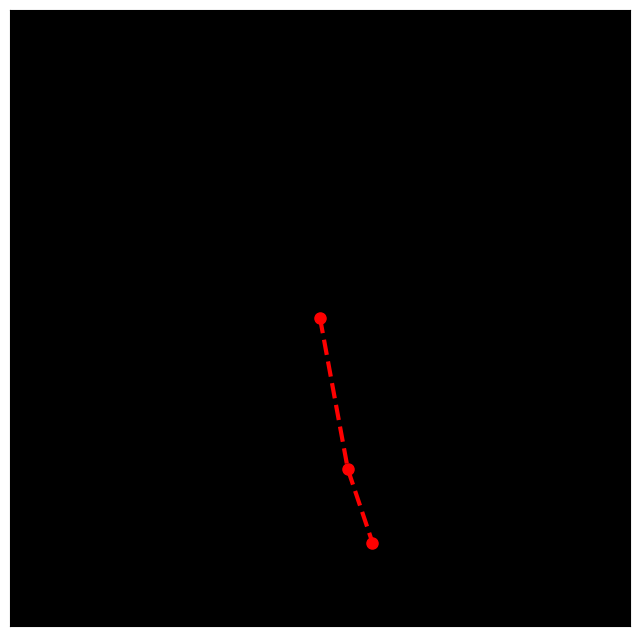

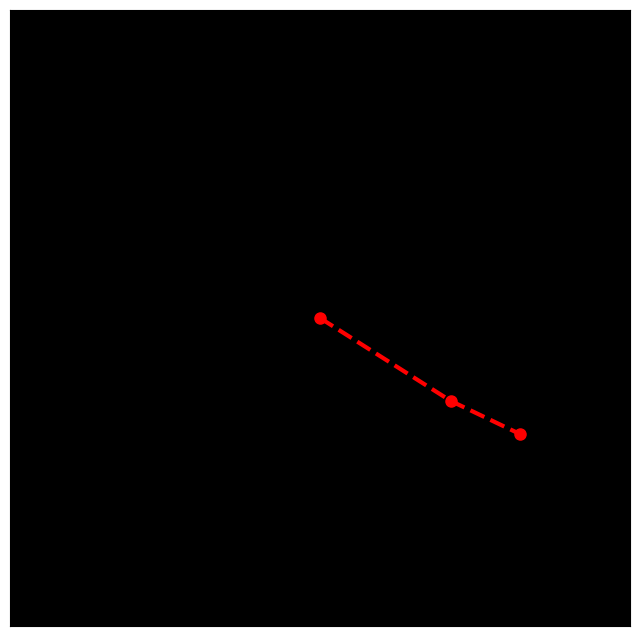

In [8]:
# animate the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
make_animation(p, time, 'arm.gif', ax, fig)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
make_animation(p_nf, time, 'arm_nf.gif', ax, fig)